In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import (classification_report, confusion_matrix,
                             ConfusionMatrixDisplay)
from pathlib import Path
from typing import List, Tuple
import seaborn as sns
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.ensemble import (AdaBoostClassifier, RandomForestClassifier,
                              ExtraTreesClassifier, VotingClassifier)

In [2]:
df= pd.read_csv('/content/dataset_augmented_crossplatform.csv')
label_col = "Benign"

In [3]:

if label_col not in df.columns:
    raise ValueError(f"'{label_col}' column not found. Update 'label_col' to match your dataset.")

print("Dataset shape:", df.shape)
print("First five rows:")
display(df.head())
RSEED      = 42

Dataset shape: (62485, 41)
First five rows:


,FileName,md5Hash,Machine,DebugSize,DebugRVA,MajorImageVersion,MajorOSVersion,ExportRVA,ExportSize,IatVRA,...,perm_STORAGE,api_SEND_SMS,url_count,ip_count,manifest_debuggable,ent_camera,ent_keychain,api_crypto_lib,uses_swift,suspicious_domain_calls
0,0124e21d-018c-4ce0-92a3-b9e205a76bc0.dll,79755c51e413ed3c6be4635fd729a6e1,332,0,0,0,4,0,0,8192,...,1,0,3,1,0,1,1,0,0,1
1,05c8318f98a5d301d80000009c316005.vertdll.dll,95e19f3657d34a432eada93221b0ea16,34404,84,121728,10,10,126576,4930,0,...,0,0,1,0,0,0,0,0,0,1
2,06054fba-5619-4a86-a861-ffb0464bef5d.dll,85c32641d77a54e19ba8ea4ab305c791,332,0,0,0,4,0,0,8192,...,1,0,1,0,0,0,1,0,0,0
3,075822ac99a5d301660400009c316005.adhapi.dll,62e3b959d982ef534b66f819fe15f085,34404,84,19904,10,10,21312,252,18160,...,0,0,1,0,0,0,1,0,1,0
4,090607dd9ba5d301ca0900009c316005.SensorsNative...,ae38c5f7d313ad0ff3bfb8826476767f,34404,84,97728,10,10,105792,1852,70592,...,1,1,0,2,0,0,0,0,0,2


In [4]:
df = df.drop(columns=['FileName', 'md5Hash'])


In [5]:
assert label_col in df.columns, f"{label_col} not found!"

In [6]:
y = df[label_col].astype(int).values

In [7]:
dynamic_cols = [c for c in df.columns if c.startswith("dyn_")]

PERM_COLS   = [c for c in df if c.startswith('perm_')]
TEXT_COLS   = [c for c in df if c.startswith('text_') or 'keyword' in c]
NET_COLS    = ['url_count', 'ip_count']
WINSEC_COLS = ['ASLR', 'DEP', 'is_packed', 'enc_keyword_score', 'import_count']
IOS_COLS    = ['ent_camera', 'ent_keychain', 'api_crypto_lib',
               'uses_swift', 'suspicious_domain_calls']

In [8]:
static_cols = [c for c in df.columns if c not in dynamic_cols + [label_col]]

In [9]:

print(f"Static feature count : {len(static_cols)}")
print(f"Dynamic feature count: {len(dynamic_cols)}")

Static feature count : 32
Dynamic feature count: 6


In [20]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

In [21]:
mi_scores = mutual_info_classif(df[static_cols], y)
mi_series = pd.Series(mi_scores, index=static_cols).sort_values(ascending=False)
STAT_SUB = mi_series[mi_series > 0.01].index.tolist()




In [23]:
mi_scores = mutual_info_classif(df[dynamic_cols], y)
mi_series = pd.Series(mi_scores, index=dynamic_cols).sort_values(ascending=False)
DYN_SUB= mi_series[mi_series > 0.01].index.tolist()

In [24]:
print(f"Selected static features: {len(STAT_SUB)}")
print(f"Selected dynamic features: {len(DYN_SUB)}")

Selected static features: 31
Selected dynamic features: 6


In [25]:
print("Available columns in df:", df.columns.tolist())
print("NET_COLS used:", NET_COLS)


Available columns in df: ['Machine', 'DebugSize', 'DebugRVA', 'MajorImageVersion', 'MajorOSVersion', 'ExportRVA', 'ExportSize', 'IatVRA', 'MajorLinkerVersion', 'MinorLinkerVersion', 'NumberOfSections', 'SizeOfStackReserve', 'DllCharacteristics', 'ResourceSize', 'BitcoinAddresses', 'Benign', 'dyn_syscall_rate', 'dyn_reg_key_mod_count', 'dyn_file_entropy', 'dyn_mem_usage_mb', 'dyn_api_seq_score', 'dyn_net_conn_attempts', 'ASLR', 'DEP', 'import_count', 'is_packed', 'enc_keyword_score', 'perm_CAMERA', 'perm_SMS', 'perm_STORAGE', 'api_SEND_SMS', 'url_count', 'ip_count', 'manifest_debuggable', 'ent_camera', 'ent_keychain', 'api_crypto_lib', 'uses_swift', 'suspicious_domain_calls']
NET_COLS used: ['url_count', 'ip_count']


In [26]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=RSEED)

In [27]:
perm_clf = RandomForestClassifier(n_estimators=200, random_state=RSEED)
text_clf = LogisticRegression(max_iter=500, n_jobs=-1, random_state=RSEED)
net_clf  = AdaBoostClassifier(random_state=RSEED)

p_perm = cross_val_predict(
    perm_clf, df[PERM_COLS], y,
    cv=skf, method='predict_proba'
)[:, 1]

p_text = cross_val_predict(
    text_clf, df[TEXT_COLS], y,
    cv=skf, method='predict_proba'
)[:, 1]

p_net = cross_val_predict(
    net_clf, df[NET_COLS], y,
    cv=skf, method='predict_proba'
)[:, 1]

p_static = (p_perm + p_text + p_net)/3


static_clf = VotingClassifier([
        ('perm', perm_clf),
        ('text', text_clf),
        ('net',  net_clf)],
    voting='soft', n_jobs=-1)


In [29]:
def soft_vote(estimators):
    return VotingClassifier(estimators=estimators, voting='soft', n_jobs=-1)

dynamic_clf = soft_vote([
    ('rf',  RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=RSEED)),
    ('et',  ExtraTreesClassifier(n_estimators=300, n_jobs=-1, random_state=RSEED)),
    ('svc', Pipeline([('sc', StandardScaler()),
                      ('clf', SVC(kernel='rbf', C=5, probability=True, random_state=RSEED))]))
])

In [30]:
df.columns

Index(['Machine', 'DebugSize', 'DebugRVA', 'MajorImageVersion',
       'MajorOSVersion', 'ExportRVA', 'ExportSize', 'IatVRA',
       'MajorLinkerVersion', 'MinorLinkerVersion', 'NumberOfSections',
       'SizeOfStackReserve', 'DllCharacteristics', 'ResourceSize',
       'BitcoinAddresses', 'Benign', 'dyn_syscall_rate',
       'dyn_reg_key_mod_count', 'dyn_file_entropy', 'dyn_mem_usage_mb',
       'dyn_api_seq_score', 'dyn_net_conn_attempts', 'ASLR', 'DEP',
       'import_count', 'is_packed', 'enc_keyword_score', 'perm_CAMERA',
       'perm_SMS', 'perm_STORAGE', 'api_SEND_SMS', 'url_count', 'ip_count',
       'manifest_debuggable', 'ent_camera', 'ent_keychain', 'api_crypto_lib',
       'uses_swift', 'suspicious_domain_calls'],
      dtype='object')

In [31]:


p_dynamic  = cross_val_predict(dynamic_clf, df[DYN_SUB], y,
                                cv=skf, method='predict_proba')[:,1]



In [32]:
y_pred = ((p_static >= 0.5) | (p_dynamic >= 0.5)).astype(int)

stat_f1  = f1_score(y, (p_static  >= 0.5))
dyn_f1   = f1_score(y, (p_dynamic >= 0.5))


In [33]:
stat_bin = (p_static  >= 0.5)
dyn_bin  = (p_dynamic >= 0.5)

In [34]:
from sklearn.metrics import f1_score, recall_score

stat_f1  = round(f1_score(y, stat_bin), 3)
stat_rec = round(recall_score(y, stat_bin), 3)

dyn_f1   = round(f1_score(y, dyn_bin), 3)
dyn_rec  = round(recall_score(y, dyn_bin), 3)

print(f"Static-only  – F1: {stat_f1}  Recall: {stat_rec}")
print(f"Dynamic-only – F1: {dyn_f1}  Recall: {dyn_rec}")


Static-only  – F1: 0.884  Recall: 0.863
Dynamic-only – F1: 1.0  Recall: 1.0


In [36]:
print(classification_report(y, y_pred, digits=3))

              precision    recall  f1-score   support

           0      1.000     0.932     0.965     35367
           1      0.918     1.000     0.957     27118

    accuracy                          0.961     62485
   macro avg      0.959     0.966     0.961     62485
weighted avg      0.965     0.961     0.962     62485



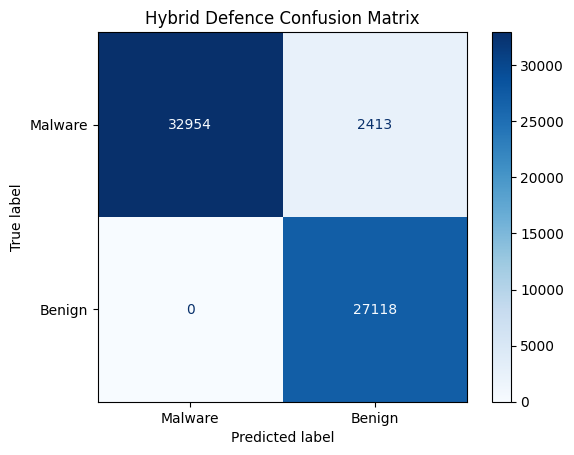

In [37]:
cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["Malware","Benign"])
disp.plot(cmap="Blues", values_format='d')
plt.title("Hybrid Defence Confusion Matrix")
plt.show()

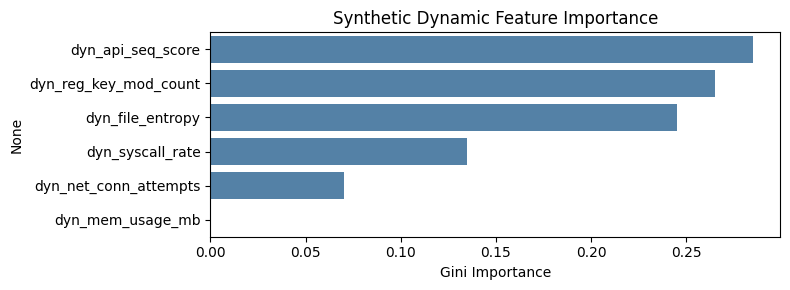

In [38]:
rf_dyn = RandomForestClassifier(n_estimators=400, random_state=RSEED)
rf_dyn.fit(df[DYN_SUB], y)
imp = pd.Series(rf_dyn.feature_importances_, index=DYN_SUB).sort_values(ascending=False)


plt.figure(figsize=(8,3))
sns.barplot(x=imp.values, y=imp.index, color='steelblue')
plt.title("Synthetic Dynamic Feature Importance")
plt.xlabel("Gini Importance")
plt.tight_layout()
plt.show()

In [40]:
quarantine_log = []
for idx, (ps, pdyn) in enumerate(zip(p_static, p_dynamic)):
    triggered_layers = []
    if ps >= 0.5:
        triggered_layers.append("Static")
    if pdyn >= 0.5:
        triggered_layers.append("Dynamic")
    if triggered_layers:
        quarantine_log.append(
            f"Sample #{idx:05d}  →  QUARANTINED (layers: {', '.join(triggered_layers)})"
        )

print("\n── Quarantine Log (first 15 entries) ──")
for line in quarantine_log[:15]:
    print(line)

print(f"\nTotal quarantined samples: {len(quarantine_log)} of {len(df)}")



── Quarantine Log (first 15 entries) ──
Sample #00000  →  QUARANTINED (layers: Static, Dynamic)
Sample #00001  →  QUARANTINED (layers: Static, Dynamic)
Sample #00002  →  QUARANTINED (layers: Static, Dynamic)
Sample #00003  →  QUARANTINED (layers: Static, Dynamic)
Sample #00004  →  QUARANTINED (layers: Static, Dynamic)
Sample #00005  →  QUARANTINED (layers: Static, Dynamic)
Sample #00006  →  QUARANTINED (layers: Static, Dynamic)
Sample #00007  →  QUARANTINED (layers: Static, Dynamic)
Sample #00008  →  QUARANTINED (layers: Static, Dynamic)
Sample #00009  →  QUARANTINED (layers: Static, Dynamic)
Sample #00010  →  QUARANTINED (layers: Static, Dynamic)
Sample #00011  →  QUARANTINED (layers: Static, Dynamic)
Sample #00012  →  QUARANTINED (layers: Static, Dynamic)
Sample #00013  →  QUARANTINED (layers: Static, Dynamic)
Sample #00014  →  QUARANTINED (layers: Static, Dynamic)

Total quarantined samples: 29531 of 62485


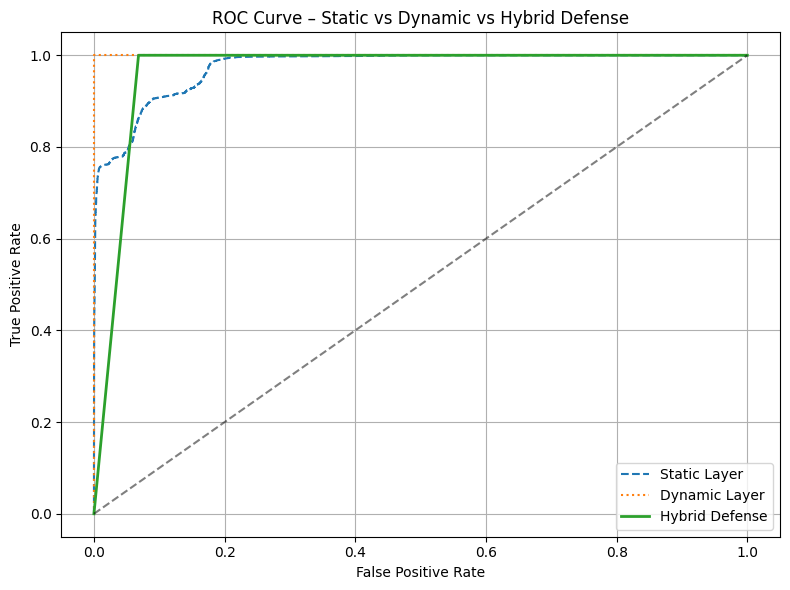

In [41]:
from sklearn.metrics import roc_curve, RocCurveDisplay

fpr_s, tpr_s, _ = roc_curve(y, p_static)
fpr_d, tpr_d, _ = roc_curve(y, p_dynamic)
fpr_h, tpr_h, _ = roc_curve(y, (p_static >= 0.5) | (p_dynamic >= 0.5))

plt.figure(figsize=(8,6))
plt.plot(fpr_s, tpr_s, label="Static Layer", linestyle='--')
plt.plot(fpr_d, tpr_d, label="Dynamic Layer", linestyle=':')
plt.plot(fpr_h, tpr_h, label="Hybrid Defense", linewidth=2)
plt.plot([0,1], [0,1], 'k--', alpha=0.5)
plt.title("ROC Curve – Static vs Dynamic vs Hybrid Defense")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


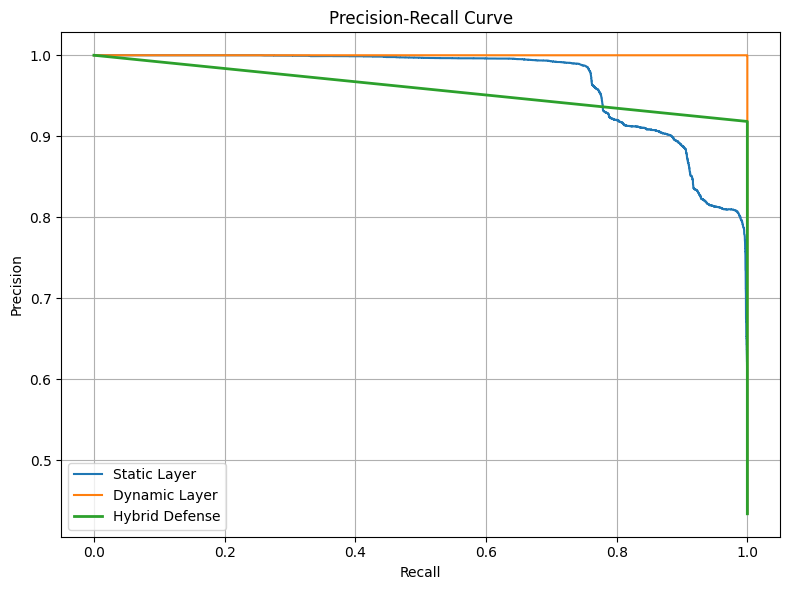

In [42]:
from sklearn.metrics import precision_recall_curve

prec_s, rec_s, _ = precision_recall_curve(y, p_static)
prec_d, rec_d, _ = precision_recall_curve(y, p_dynamic)
prec_h, rec_h, _ = precision_recall_curve(y, (p_static >= 0.5) | (p_dynamic >= 0.5))

plt.figure(figsize=(8,6))
plt.plot(rec_s, prec_s, label="Static Layer")
plt.plot(rec_d, prec_d, label="Dynamic Layer")
plt.plot(rec_h, prec_h, label="Hybrid Defense", linewidth=2)
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



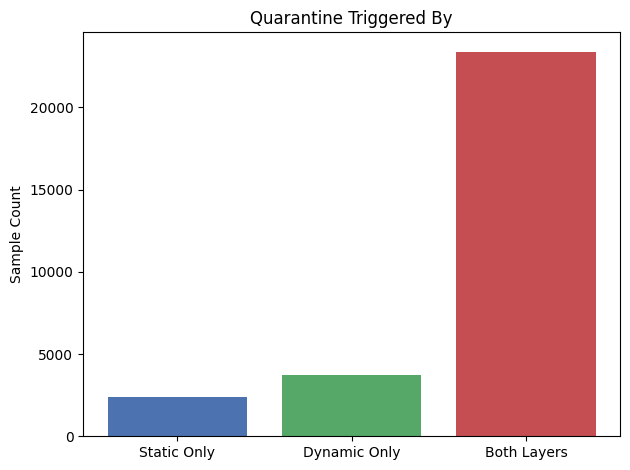

In [43]:
only_static  = sum((p_static >= 0.5) & (p_dynamic < 0.5))
only_dynamic = sum((p_dynamic >= 0.5) & (p_static < 0.5))
both_layers  = sum((p_static >= 0.5) & (p_dynamic >= 0.5))

labels = ['Static Only', 'Dynamic Only', 'Both Layers']
values = [only_static, only_dynamic, both_layers]

plt.bar(labels, values, color=['#4c72b0', '#55a868', '#c44e52'])
plt.title("Quarantine Triggered By")
plt.ylabel("Sample Count")
plt.tight_layout()
plt.show()



In [44]:
import joblib
joblib.dump(static_clf, 'static_clf.pkl')
joblib.dump(dynamic_clf, 'dynamic_clf.pkl')


['dynamic_clf.pkl']

In [ ]:


from sklearn.metrics import f1_score


def bit_flip_matrix(X_df, n_bits, seed=0):
    np.random.seed(seed)
    X = X_df.copy().values
    m, n = X.shape
    for _ in range(n_bits):
        i = np.random.randint(0, m)
        j = np.random.randint(0, n)
        X[i, j] = 1 - X[i, j]
    return pd.DataFrame(X, columns=X_df.columns, index=X_df.index)

baseline_f1 = f1_score(y, ((p_static >= 0.5) | (p_dynamic >= 0.5)).astype(int))
print(f"Baseline F1: {baseline_f1:.3f}")


print("\nBits |   F1   | ΔF1")
for n_bits in [1, 10, 20, 30, 40]:

    flipped_perm_df = bit_flip_matrix(df[PERM_COLS], n_bits)


    p_perm_flip = cross_val_predict(
        perm_clf, flipped_perm_df, y,
        cv=skf, method='predict_proba'
    )[:, 1]


    p_static_adv  = (p_perm_flip+ p_text + p_net)/3

    y_hybrid_adv = ((p_static_adv >= 0.5) | (p_dynamic >= 0.5)).astype(int)

    adv_f1 = f1_score(y, y_hybrid_adv)
    print(f"{n_bits:>4} | {adv_f1:.3f} | {adv_f1 - baseline_f1:+.3f}")


Baseline F1: 0.957

Bits |   F1   | ΔF1
   1 | 0.957 | +0.000
  10 | 0.957 | +0.000
  20 | 0.957 | +0.000
  30 | 0.957 | +0.000
  40 | 0.957 | +0.000


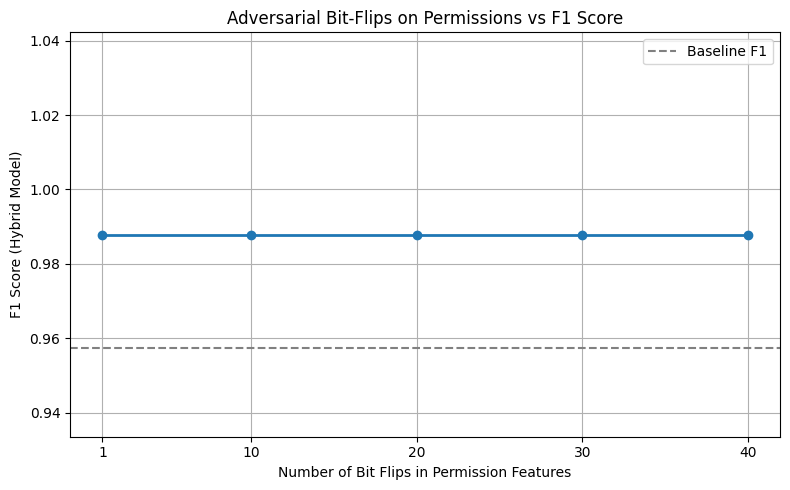

In [ ]:
import matplotlib.pyplot as plt

bit_counts = [1, 10, 20, 30, 40]
f1_scores = []

for n_bits in bit_counts:
    flipped_perm_df = bit_flip_matrix(df[PERM_COLS], n_bits)
    p_perm_flip = cross_val_predict(perm_clf, flipped_perm_df, y, cv=skf, method='predict_proba')[:, 1]
    p_static_adv = (p_perm_flip + p_text +p_net)/3
    y_hybrid_adv = ((p_static_adv >= 0.5) | (p_dynamic >= 0.5)).astype(int)
    adv_f1 = f1_score(y, y_hybrid_adv)
    f1_scores.append(adv_f1)


plt.figure(figsize=(8, 5))
plt.plot(bit_counts, f1_scores, marker='o', linewidth=2)
plt.axhline(baseline_f1, color='gray', linestyle='--', label='Baseline F1')
plt.title("Adversarial Bit-Flips on Permissions vs F1 Score")
plt.xlabel("Number of Bit Flips in Permission Features")
plt.ylabel("F1 Score (Hybrid Model)")
plt.ticklabel_format(axis='y', style='plain', useOffset=False)

plt.xticks(bit_counts)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:

target_bits = ['perm_CAMERA', 'perm_SMS', 'perm_STORAGE']

flipped_df = df[PERM_COLS].copy()
for bit in target_bits:
    if bit in flipped_df.columns:
        flipped_df[bit] = 1 - flipped_df[bit]   


p_perm_flip = cross_val_predict(
    perm_clf, flipped_df, y,
    cv=skf, method='predict_proba'
)[:, 1]


p_static_tgt = (p_perm_flip + p_text + p_net) / 3     


y_hybrid_tgt = ((p_static_tgt >= 0.5) | (p_dynamic >= 0.5)).astype(int)
adv_f1 = f1_score(y, y_hybrid_tgt)
print(f" Targeted Flip ({', '.join(target_bits)}) → F1: {adv_f1:.3f} | ΔF1: {adv_f1 - baseline_f1:+.3f}")


 Targeted Flip (perm_CAMERA, perm_SMS, perm_STORAGE) → F1: 0.988 | ΔF1: +0.030


In [52]:
evaded_dyn_df = df[DYN_SUB].copy()


top_dyn_features = imp.head(3).index.tolist()
for col in top_dyn_features:
    if col in evaded_dyn_df.columns:
        evaded_dyn_df[col] = 0

p_dyn_evaded = cross_val_predict(dynamic_clf, evaded_dyn_df, y, cv=skf, method='predict_proba')[:, 1]
y_hybrid_evaded = ((p_static >= 0.5) | (p_dyn_evaded >= 0.5)).astype(int)
evaded_f1 = f1_score(y, y_hybrid_evaded)

print(f" Simulated Dynamic Evasion → F1: {evaded_f1:.3f} | ΔF1: {evaded_f1 - baseline_f1:+.3f}")


 Simulated Dynamic Evasion → F1: 0.957 | ΔF1: +0.000


In [53]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

def report_metrics(name, y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)
    auc = roc_auc_score(y_true, y_prob)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"{name:<6} | AUC: {auc:.3f} | Acc: {acc:.3f} | Prec: {prec:.3f} | Rec: {rec:.3f} | F1: {f1:.3f}")

print("Model Performance ")
report_metrics("Perm", y, p_perm)
report_metrics("Text", y, p_text)
report_metrics("Net",  y, p_net)
report_metrics("Dyn",  y, p_dynamic)
report_metrics("Static", y, p_static)
report_metrics("Hybrid", y, ((p_static >= 0.5) | (p_dynamic >= 0.5)).astype(int))  # Binary hybrid




Model Performance 
Perm   | AUC: 0.880 | Acc: 0.817 | Prec: 0.792 | Rec: 0.783 | F1: 0.788
Text   | AUC: 0.978 | Acc: 0.932 | Prec: 0.922 | Rec: 0.921 | F1: 0.921
Net    | AUC: 0.986 | Acc: 0.946 | Prec: 0.932 | Rec: 0.944 | F1: 0.938
Dyn    | AUC: 1.000 | Acc: 1.000 | Prec: 1.000 | Rec: 1.000 | F1: 1.000
Static | AUC: 0.974 | Acc: 0.902 | Prec: 0.907 | Rec: 0.863 | F1: 0.884
Hybrid | AUC: 0.966 | Acc: 0.961 | Prec: 0.918 | Rec: 1.000 | F1: 0.957
